# About the notebook

In [1]:
### import libraries
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(MPSK)))
suppressMessages(suppressWarnings(library(tsne)))

suppressMessages(suppressWarnings(library(flowCore)))
suppressMessages(suppressWarnings(library(flowStats)))
suppressMessages(suppressWarnings(library(flowViz)))
suppressMessages(suppressWarnings(library(flowMatch)))
suppressMessages(suppressWarnings(library(flowMap)))

suppressMessages(suppressWarnings(library(igraph)))
suppressMessages(suppressWarnings(library(pheatmap)))
suppressMessages(suppressWarnings(library(RColorBrewer)))
suppressMessages(suppressWarnings(library(gplots)))

### set directories
dat_dir = "/data/clintko/SMPK"

# Import data

previous code

```
%%Python
target_dir = "/data/SMPK"
with open(os.path.join(target_dir, "res0_GEN070XT_CMVpp65.pic"), 'rb') as f:
    res = pickle.load(f)

%%R -i res
resRelab      = relabelChain(res)
resCalibrated = calibrate(resRelab)
chainSummary  = summarizeChain(resRelab)
```

import results from MPSK

In [2]:
dat_mpsk_raw  = read_delim(file.path(dat_dir, "ep8cs_dat_mpsk_raw.txt"),  delim = "\t")
dat_mpsk_cal  = read_delim(file.path(dat_dir, "ep8cs_dat_mpsk_cal.txt"),  delim = "\t")
dat_gaussnorm = read_delim(file.path(dat_dir, "ep8cs_dat_gaussnorm.txt"), delim = "\t")

Parsed with column specification:
cols(
  sample = col_character(),
  cluster = col_integer(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)
Parsed with column specification:
cols(
  sample = col_character(),
  cluster = col_integer(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)
Parsed with column specification:
cols(
  sample = col_character(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)


In [3]:
dim(dat_mpsk_raw)
dim(dat_mpsk_cal)
dim(dat_gaussnorm)

[1] 180000     12

[1] 180000     12

[1] 180000     11

# Comparing Labels using FlowMatch

### Observe the labels of each sample

In [4]:
### initialization
idxs = str_pad(1:18, 2, pad = "0")
dat  = dat_mpsk_raw

### take a look at the labels of each sample
lapply(idxs, function(idx) {
    ### sample of each data
    dat_sub = dat %>% dplyr::filter(sample == idx)
    
    ### extract the cluster of each subsample
    clust   = dat_sub$cluster %>% sort %>% unique
    
    return(clust)
}) # end lapply

[[1]]
[1]  1  2  3  4  6  8  9 10

[[2]]
[1]  1  2  3  4  6  7  8  9 10

[[3]]
[1]  1  2  3  4  6  8  9 10

[[4]]
[1]  1  2  3  4  6  7  8  9 10

[[5]]
[1]  1  2  3  4  6  7  8  9 10

[[6]]
[1]  1  2  3  4  6  7  8  9 10

[[7]]
[1]  1  2  3  4  6  7  8  9 10

[[8]]
[1]  1  2  3  4  6  8  9 10

[[9]]
[1]  1  2  3  4  6  7  8  9 10

[[10]]
[1]  1  2  3  4  6  8  9 10

[[11]]
[1]  1  2  3  4  6  7  8  9 10

[[12]]
[1]  1  2  3  4  6  7  8  9 10

[[13]]
[1]  1  2  3  4  6  8  9 10

[[14]]
[1]  1  2  3  4  6  7  8  9 10

[[15]]
[1]  1  2  3  4  6  7  8  9 10

[[16]]
[1]  1  2  3  4  6  7  8  9 10

[[17]]
[1]  1  2  3  4  6  8  9 10

[[18]]
[1]  1  2  3  4  6  7  8  9 10

**However, the flowMatch function does not accept un-sequential label**

`ClusteredSample(labels, centers=list(), covs=list(), sample=NULL, sample.id=NA_integer_)`

- **labels**
    - A vector of integers (from <font color="red">1:num.clusters</font>) indicating the cluster to which each point is allocated. This is usually obtained from a clustering algorithm.
- **sample** 
    - A matrix, data frame of observations, or object of class flowFrame. Rows correspond to observations and columns correspond to variables. It must be passed to the constructor if either centers or cov is unspecified; then centers or cov is estimated from sample.

In [5]:
### subset data by index of sample
dat_sub  = dat %>% dplyr::filter(sample == "01") 

### get the data frame and cluster
mat   = dat_sub %>% dplyr::select(-sample, -cluster)
clust = dat_sub$cluster
   
### create ClusteredSample and return
ClusteredSample(labels = clust, sample = mat)

ERROR: Error in validityMethod(object): dimension of a cluster does not match the dimension of the sample


<font color = "red">**To solve the problem, I need to switch the cluster label 10 $\to$ 5 and exchange label 7 and 9.**</font>

example

In [6]:
c(1, 10, 5, 7, 9, 7) %>% as.character %>% recode(., "10" = "5", "7" = "9", "9" = "7")

[1] "1" "5" "5" "9" "7" "9"

### rename clusters for applying the flowMatch methods on cluster id and data

rename the clusters label on our dataframe

In [8]:
dat = dat_mpsk_raw

### map 10 to 5 and 9 to 7
### so that the cluster labels continuous from 1 to 7
dat$cluster = dat$cluster %>% 
    as.character %>% 
    recode(., "10" = "5", "7" = "9", "9" = "7") %>%
    as.integer

dat_mpsk2_raw = dat

do the same thing to the mpsk calibrated data

In [9]:
dat = dat_mpsk_cal

### map 10 to 5 and 9 to 7
### so that the cluster labels continuous from 1 to 7
dat$cluster = dat$cluster %>% 
    as.character %>% 
    recode(., "10" = "5", "7" = "9", "9" = "7") %>%
    as.integer

dat_mpsk2_cal = dat

### test flowMatch on raw data

take a look at our data

In [10]:
head(dat_mpsk2_raw, 3)

sample,cluster,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,4,-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.2734487,0.60710339
01,3,-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.3496486,-0.03757027
01,1,0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.4259069,-0.02672243


example to compare clusters between two samples

In [11]:
create_cluster_sample = function(dat, idx_sample) {
    # helper function to create clusteredSample object
    ############################################
    ### subset data by index of sample
    dat_sub  = dat %>% dplyr::filter(sample == idx_sample) 
    
    ### get the data frame and cluster
    mat      = dat_sub %>% dplyr::select(-sample, -cluster)
    clust    = dat_sub$cluster
   
    ### create ClusteredSample and return
    res = ClusteredSample(labels = clust, sample = mat)
    return(res)

} # end func

### set referece -> cluster == 1 
clustRef = create_cluster_sample(dat_mpsk2_raw, "02")
clustSam = create_cluster_sample(dat_mpsk2_raw, "01")

mec = match.clusters(clustRef, clustSam, dist.type="Mahalanobis", unmatch.penalty=99999)
summary(mec)

clusters/meta-clusters      matched clusters/meta-clusters
from sample1/template1      sample2/template2 
           1                            1
           2                            2
           3                            3
           4                            4
           5                            5
           6                            6
           7                            7
           8                            8
           9                            5


In [12]:
combine_sample_cluster = function(mec, idx1, idx2){
    # the function is aimed to convert list of matched clusters into a dataframe
    ###################################
    res = mec@match12
    res = sapply(res, function(x){as.character(paste(x, collapse = ","))})
    res = data.frame(idx1 = 1:length(res), idx2 = res)
    res = res %>% dplyr::mutate(idx2 = strsplit(as.character(idx2), ",")) %>% tidyr::unnest(idx2)
    colnames(res) = c(idx1, idx2)
    return(res)
} # end func

combine_sample_cluster(mec, "01", "03")

01,03
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,5


### apply flowMatch on raw data 

helper function

In [13]:
### helper function
mycombine = function(dat1, dat2) {
    # function combine all the matched index from flowMatch
    #######################################################
    dat = full_join(dat1, dat2, by = "02")
    return(dat)
} # end func

apply flowMatch on raw data

In [55]:
### initialization
dat      = dat_mpsk2_raw
ref      = str_pad(   2, 2, pad = "0")
idxs     = str_pad(1:18, 2, pad = "0")
clustRef = create_cluster_sample(dat, ref)

### foreach loop to combine all the matched cluster labels
dat_match_labels = foreach(idx = setdiff(idxs, ref), .combine = mycombine) %dopar% {
    ### create clustered sample
    clustSam = create_cluster_sample(dat, idx)
    
    ### match clusters
    mec = match.clusters(
        clustRef, 
        clustSam,
        dist.type="Mahalanobis", 
        unmatch.penalty=99999)
    
    ### convert the matched results into data frame
    res = combine_sample_cluster(mec, ref, idx)
    return(res)
}

### remapping back the cluster label
dat_match_labels = apply(dat_match_labels, 2, function(x){recode(x, "5" = "10", "7" = "9", "9" = "7")})
rownames(dat_match_labels) = paste("Cluster", c(1, 2, 3, 4, 10, 6, 9, 8, 7))
colnames(dat_match_labels) = paste("Sample", colnames(dat_match_labels))
dat_match_labels = t(dat_match_labels)
dat_match_labels

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 10,Cluster 6,Cluster 9,Cluster 8,Cluster 7
Sample 02,1,2,3,4,10,6,9,8,7
Sample 01,1,2,3,4,10,6,9,8,10
Sample 03,1,2,3,4,10,6,9,8,10
Sample 04,1,2,3,4,10,6,9,8,7
Sample 05,1,2,3,4,10,6,9,8,7
Sample 06,1,2,3,4,7,6,9,8,10
Sample 07,1,2,3,4,10,6,9,8,7
Sample 08,6,10,3,4,2,9,6,8,1
Sample 09,1,2,3,4,10,6,9,8,7
Sample 10,1,2,3,4,10,6,9,8,10


### apply flowMatch on calibrated data

In [56]:
### initialization
dat      = dat_mpsk2_cal
ref      = str_pad(   2, 2, pad = "0")
idxs     = str_pad(1:18, 2, pad = "0")
clustRef = create_cluster_sample(dat, ref)

### foreach loop to combine all the matched cluster labels
dat_match_labels = foreach(idx = setdiff(idxs, ref), .combine = mycombine) %dopar% {
    ### create clustered sample
    clustSam = create_cluster_sample(dat, idx)
    
    ### match clusters
    mec = match.clusters(
        clustRef, 
        clustSam,
        dist.type="Mahalanobis", 
        unmatch.penalty=99999)
    
    ### convert the matched results into data frame
    res = combine_sample_cluster(mec, ref, idx)
    return(res)
}

### remapping back the cluster label
dat_match_labels = apply(dat_match_labels, 2, function(x){recode(x, "5" = "10", "7" = "9", "9" = "7")})
rownames(dat_match_labels) = paste("Cluster", c(1, 2, 3, 4, 10, 6, 9, 8, 7))
colnames(dat_match_labels) = paste("Sample", colnames(dat_match_labels))
dat_match_labels = t(dat_match_labels)
dat_match_labels

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 10,Cluster 6,Cluster 9,Cluster 8,Cluster 7
Sample 02,1,2,3,4,10,6,9,8,7
Sample 01,1,2,3,4,10,6,9,8,10
Sample 03,1,2,3,4,10,6,9,8,10
Sample 04,1,2,3,4,10,6,9,8,7
Sample 05,1,2,3,4,10,6,9,8,7
Sample 06,1,2,3,4,10,6,9,8,7
Sample 07,1,2,3,4,10,6,9,8,7
Sample 08,1,2,3,4,10,6,9,8,10
Sample 09,1,2,3,4,10,6,9,8,7
Sample 10,1,2,3,4,10,6,9,8,10


## <font color = "red">**Interestingly, after calibration, the label of sample 08 no longer has mismatch with the reference (sample 01)**</font>

### Visualization

In [57]:
head(dat_mpsk_raw)

sample,cluster,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,4,-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.27344867,0.60710339
01,3,-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.34964856,-0.03757027
01,1,0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.42590688,-0.02672243
01,4,-1.5681802,-0.57996979,-0.5588165,0.2319850,1.8415205,-0.1502302,-0.5595654,0.02146696,-0.51009832,-0.01391902
01,8,-1.5371229,0.32463843,-0.2535651,-0.6772130,2.0872188,-1.3166316,-0.6453749,-0.22168409,-0.88871667,0.15053694
01,1,-0.2959737,-0.29703637,-0.2005701,-0.6302307,0.4919176,-0.8454200,-0.2646515,2.44124150,0.02647195,0.33899091


before MPSK calibration

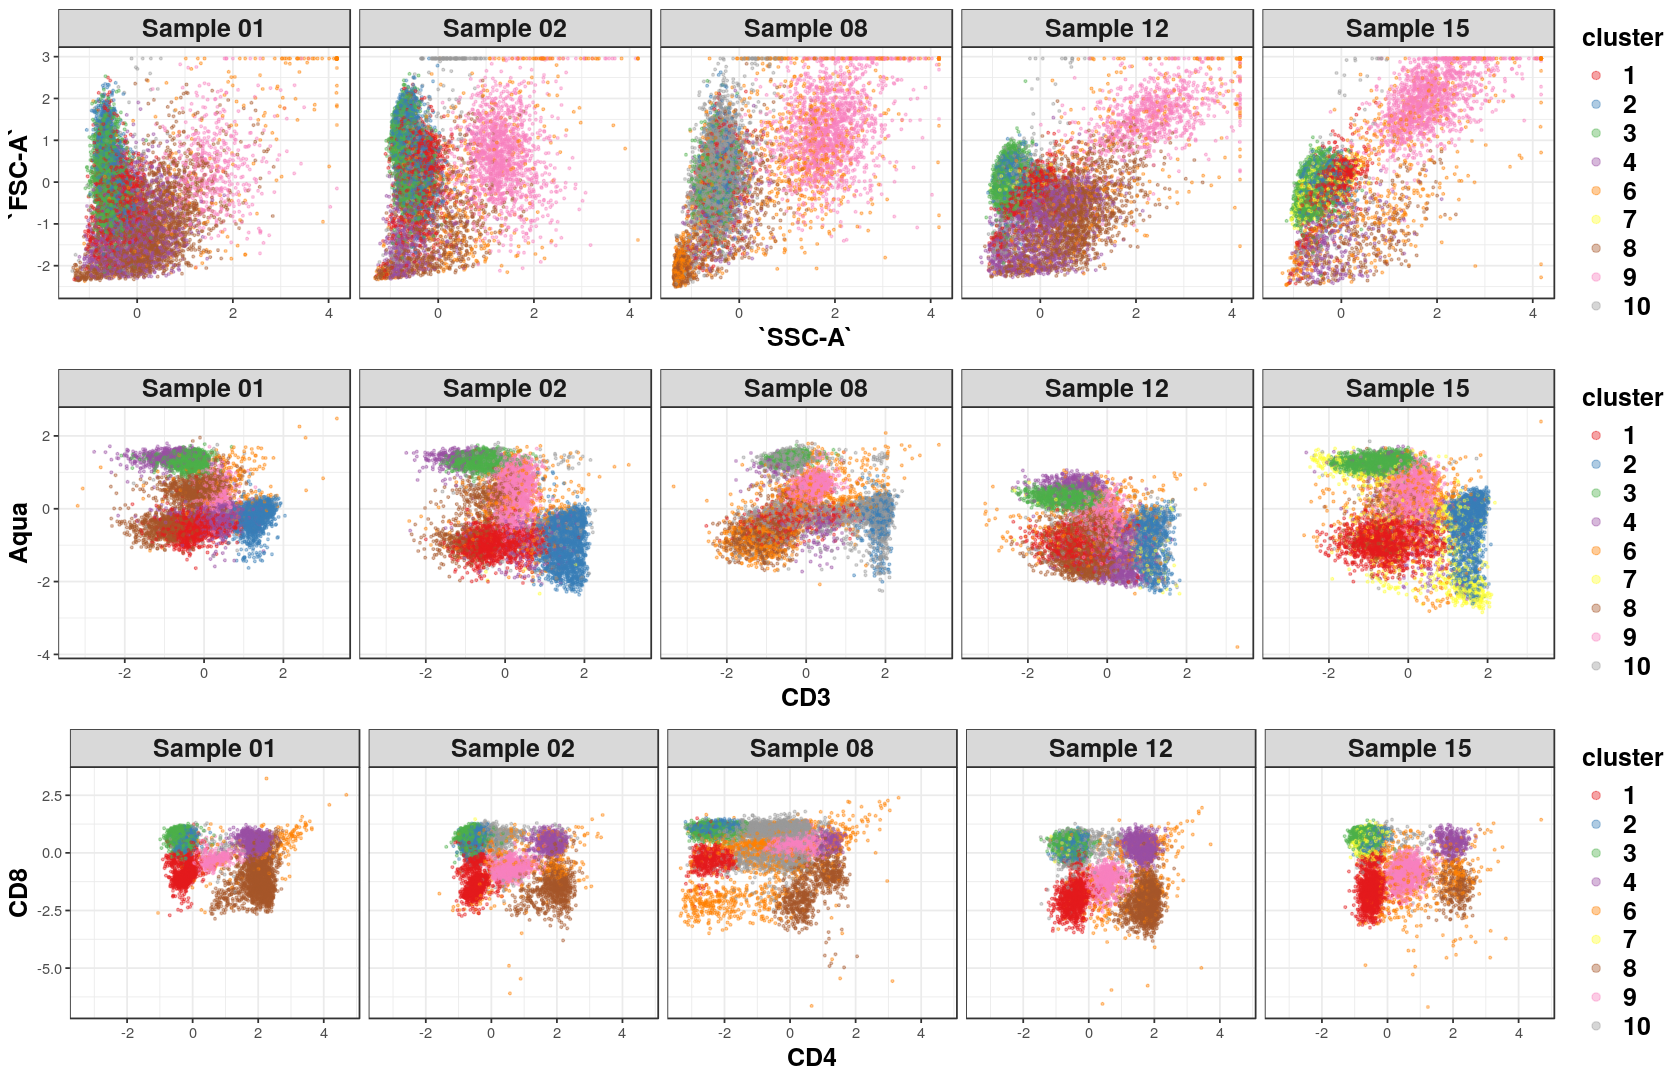

In [58]:
my_cols = brewer.pal(10, "Set3")

dat = dat_mpsk_raw
dat = dat %>% dplyr::filter(sample %in% c("01", "02", "08", "12", "15"))
dat$sample  = paste("Sample", dat$sample)
dat$cluster = factor(dat$cluster)

gp1 = dat %>% ggplot(., aes(x = `SSC-A`, y = `FSC-A`, color = cluster)) + 
          geom_point(size = 0.5, alpha = 0.4) + 
          scale_color_brewer(palette = "Set1") +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

gp2 = dat %>% ggplot(., aes(x = CD3, y = Aqua, color = cluster)) + 
          geom_point(size = 0.5, alpha = 0.4) +
          scale_color_brewer(palette = "Set1") +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

gp3 = dat %>% ggplot(., aes(x = CD4, y = CD8, color = cluster)) + 
          geom_point(size = 0.5, alpha = 0.4) +
          scale_color_brewer(palette = "Set1") +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

options(repr.plot.width = 14, repr.plot.height = 9)
gridExtra::grid.arrange(gp1, gp2, gp3)

After MPSK calibration

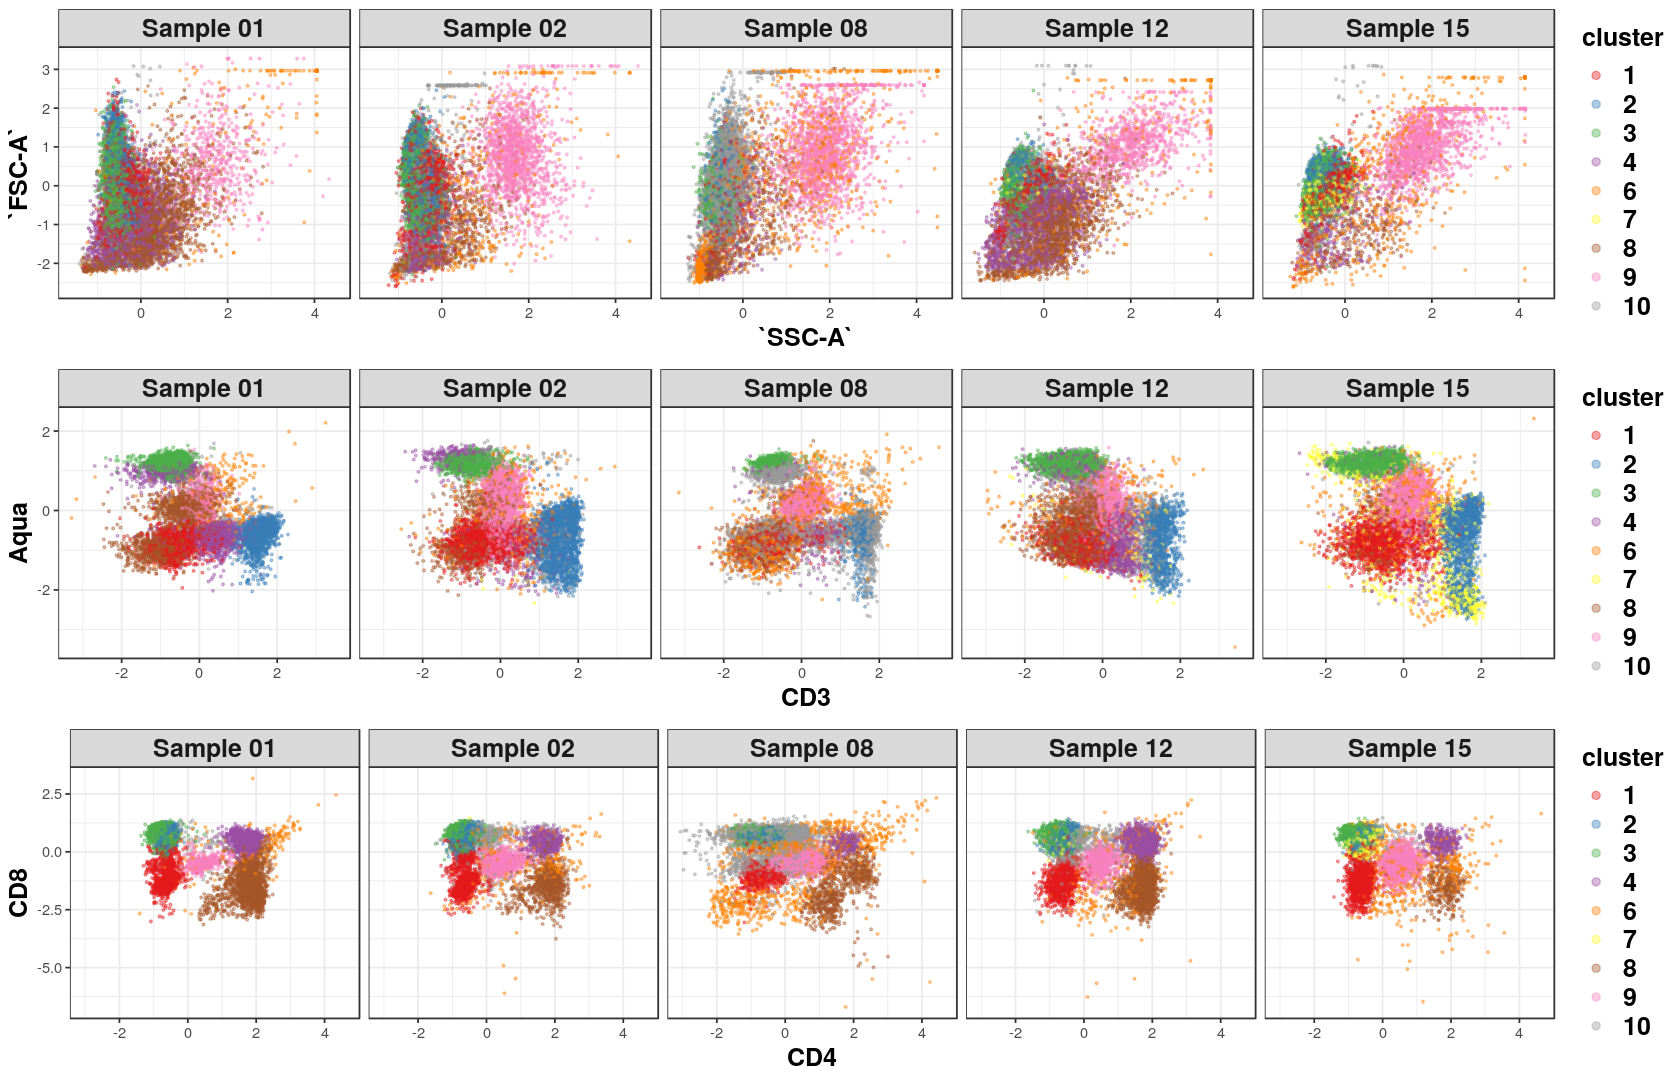

In [59]:
dat = dat_mpsk_cal
dat = dat %>% dplyr::filter(sample %in% c("01", "02", "08", "12", "15"))
dat$sample  = paste("Sample", dat$sample)
dat$cluster = factor(dat$cluster)

gp1 = dat %>% ggplot(., aes(x = `SSC-A`, y = `FSC-A`, color = cluster)) + 
          geom_point(size = 0.5, alpha = 0.4) + 
          scale_color_brewer(palette = "Set1") +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

gp2 = dat %>% ggplot(., aes(x = CD3, y = Aqua, color = cluster)) + 
          geom_point(size = 0.5, alpha = 0.4) +
          scale_color_brewer(palette = "Set1") +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

gp3 = dat %>% ggplot(., aes(x = CD4, y = CD8, color = cluster)) + 
          geom_point(size = 0.5, alpha = 0.4) +
          scale_color_brewer(palette = "Set1") +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

options(repr.plot.width = 14, repr.plot.height = 9)
gridExtra::grid.arrange(gp1, gp2, gp3)

take a look at cluster label 7 and 10 (before calibration)

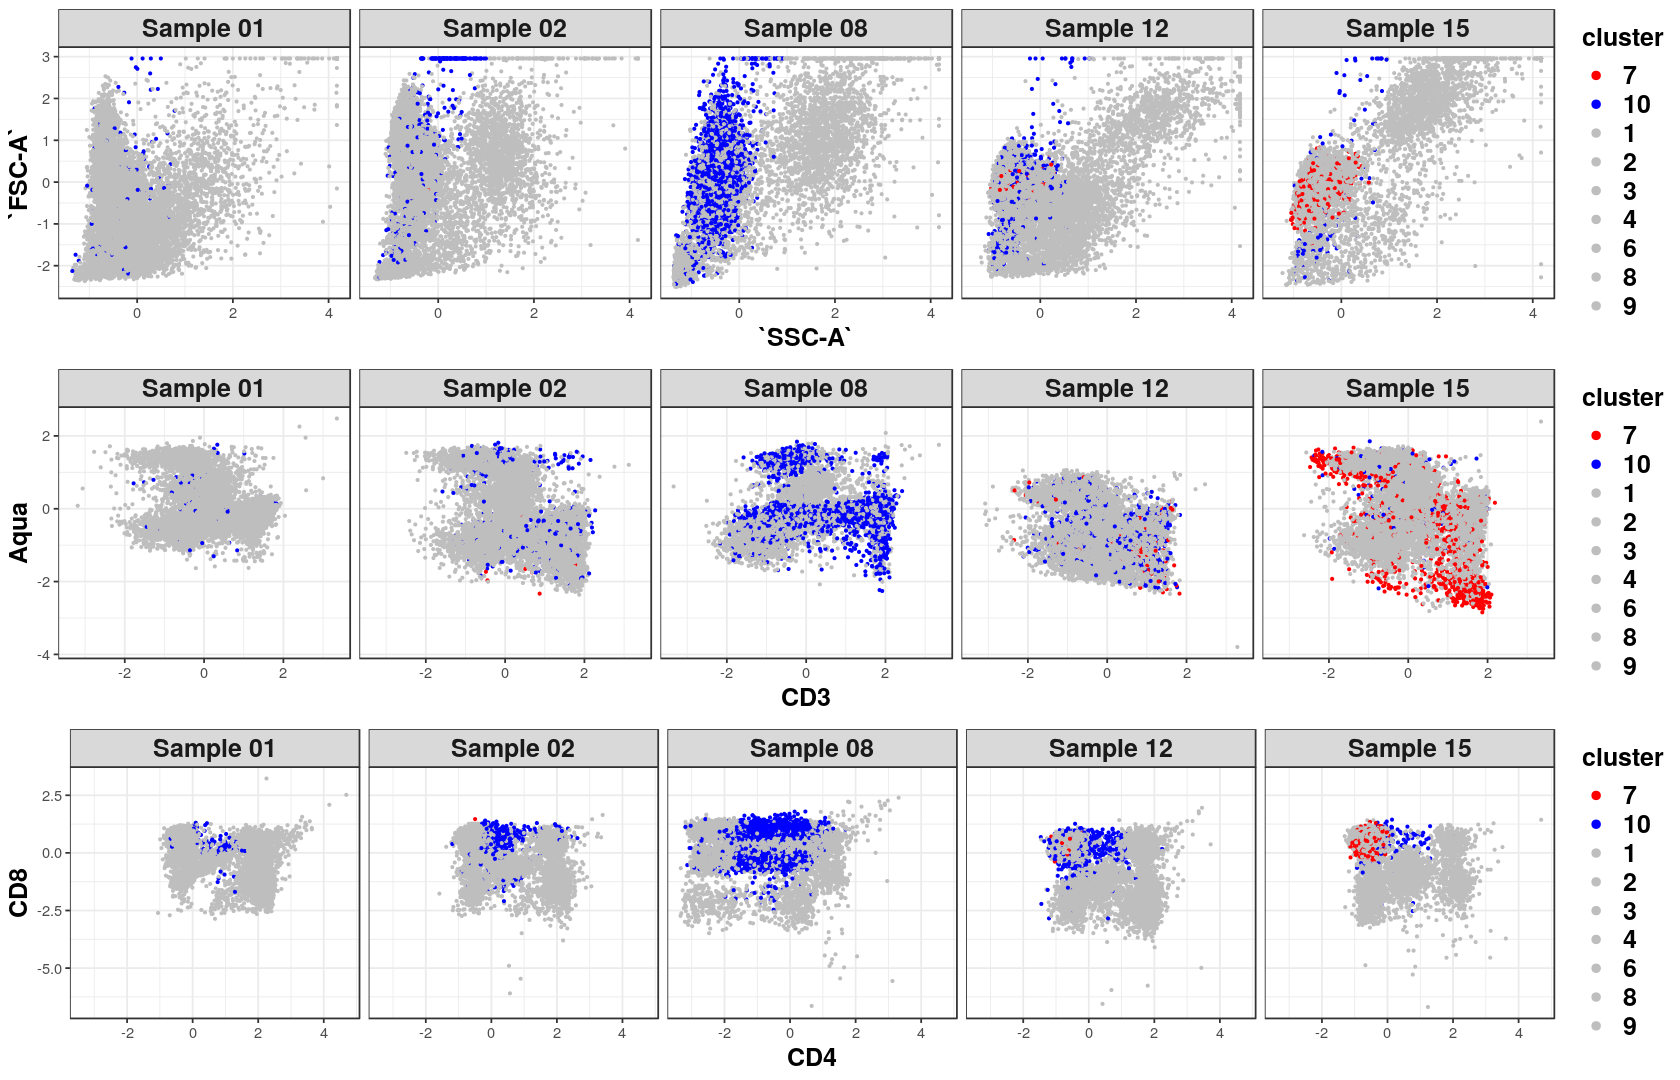

In [78]:
### choose samples
dat = dat_mpsk_raw
dat = dat %>% dplyr::filter(sample %in% c("01", "02", "08", "12", "15"))
dat$sample  = paste("Sample", dat$sample)

### set colors for clusters
clusters = c(7, 10, 1, 2, 3, 4, 6, 8, 9)
cols = c("red", "blue", rep("grey", 7))
names(cols) = clusters
dat$cluster = factor(dat$cluster, levels = clusters)

### visualization
gp1 = dat %>% ggplot(., aes(x = `SSC-A`, y = `FSC-A`, color = cluster)) + 
          geom_point(size = 0.5) + 
          scale_color_manual(values = cols) +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

gp2 = dat %>% ggplot(., aes(x = CD3, y = Aqua, color = cluster)) + 
          geom_point(size = 0.5) +
          scale_color_manual(values = cols) +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

gp3 = dat %>% ggplot(., aes(x = CD4, y = CD8, color = cluster)) + 
          geom_point(size = 0.5) +
          scale_color_manual(values = cols) +
          facet_wrap(~sample, nrow = 1) +
          theme_bw() +
          guides(colour = guide_legend(override.aes = list(size=2))) +
          theme(legend.title = element_text(size = 15, face = "bold"),
              legend.text  = element_text(size = 15, face = "bold"),
              strip.text   = element_text(size = 15, face = "bold"),
              axis.title   = element_text(size = 15, face = "bold"))

options(repr.plot.width = 14, repr.plot.height = 9)
gridExtra::grid.arrange(gp1, gp2, gp3)

# Comparing Labels using FlowMap

arrange data to use the flowmap

In [19]:
dat  = dat_mpsk_raw
dat  = dat %>% dplyr::select(-cluster) %>% dplyr::mutate(cluster = dat$cluster)

idx  = "01"
dat1_raw        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat1_clust1_raw = dat1_raw %>% dplyr::filter(cluster == 1) 

idx  = "02"
dat2_raw        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat2_clust1_raw = dat2_raw %>% dplyr::filter(cluster == 1) 

#####################################

dat  = dat_mpsk_cal
dat  = dat %>% dplyr::select(-cluster) %>% dplyr::mutate(cluster = dat$cluster)

idx  = "01"
dat1_cal        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat1_clust1_cal = dat1_cal %>% dplyr::filter(cluster == 1) 

idx  = "02"
dat2_cal        = dat      %>% dplyr::filter(sample == idx) %>% dplyr::select(-sample)
dat2_clust1_cal = dat2_cal %>% dplyr::filter(cluster == 1)

### Example of using flowmap
flowMap quantifies the similarity of cell populations across multiple flow cytometry samples using a nonparametric multivariate statistical test.

The concept of flowMap is to create a minimum spanning tree among the two compared population. If two populations are similar to each other, the nodes from both population distributed evenly in the tree. Below is a demonstration where I compared a population of data points to itself.

Warning message in graph.adjacency(distmat * mstree, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”Warning message in graph.adjacency(distmat, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”

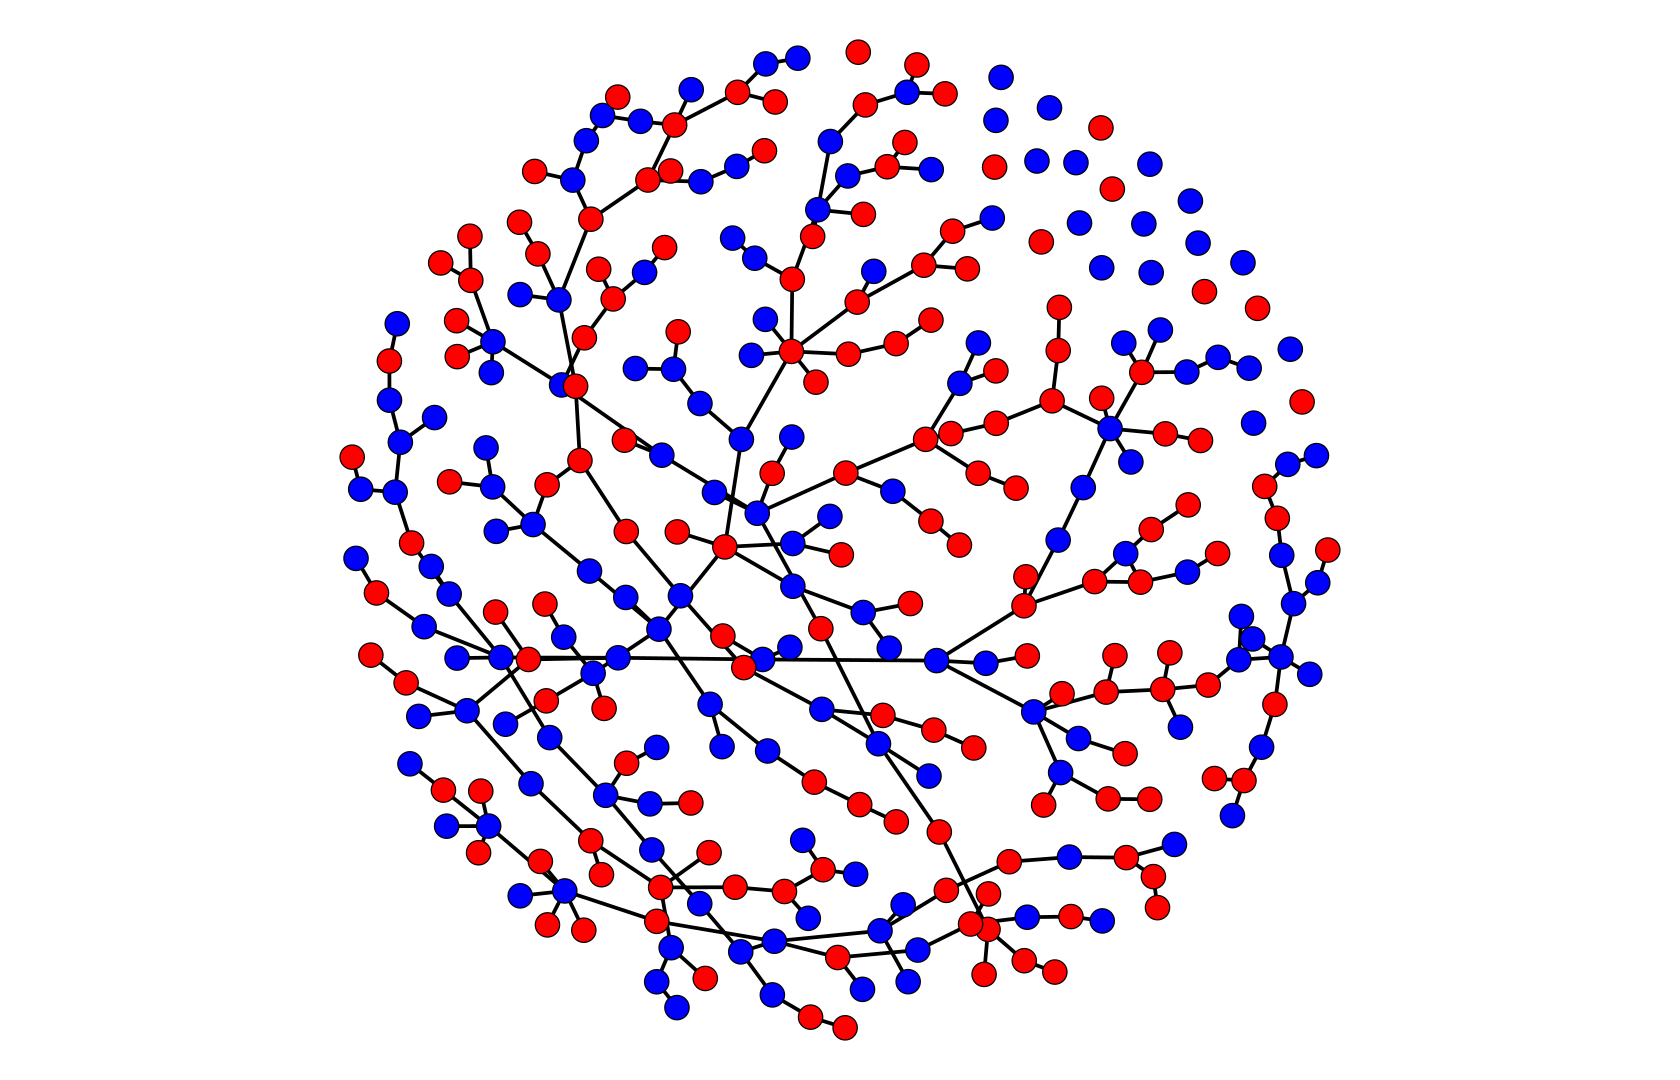

In [20]:
###
tmp1 = dat1_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 1) %>% sample_frac(size = 0.1)
tmp2 = dat1_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 2) %>% sample_frac(size = 0.1)
dat_sub = rbind(tmp1, tmp2)

###
set.seed(123)
g1 = makeFRMST(dat_sub)

###
par(mar=c(0,0,0,0))
plot(g1$g, 
     vertex.label.cex=0.01,
     layout=layout.fruchterman.reingold(g1$g))

In [21]:
tmp1 = dat1_raw
colnames(tmp1) = colnames(tmp1) %>% recode("cluster" = "id")

tmp2 = dat1_raw
colnames(tmp2) = colnames(tmp2) %>% recode("cluster" = "id")


res0 = getFRest(
    tmp1, tmp2,
    #sampleMethod="equalSize",
    sampleMethod="proportional",
    sampleSize=100,
    ndraws=100,
    estStat="median",
    ncores=NULL)

computing on 24 cores
computing FR statistics between sample ... 



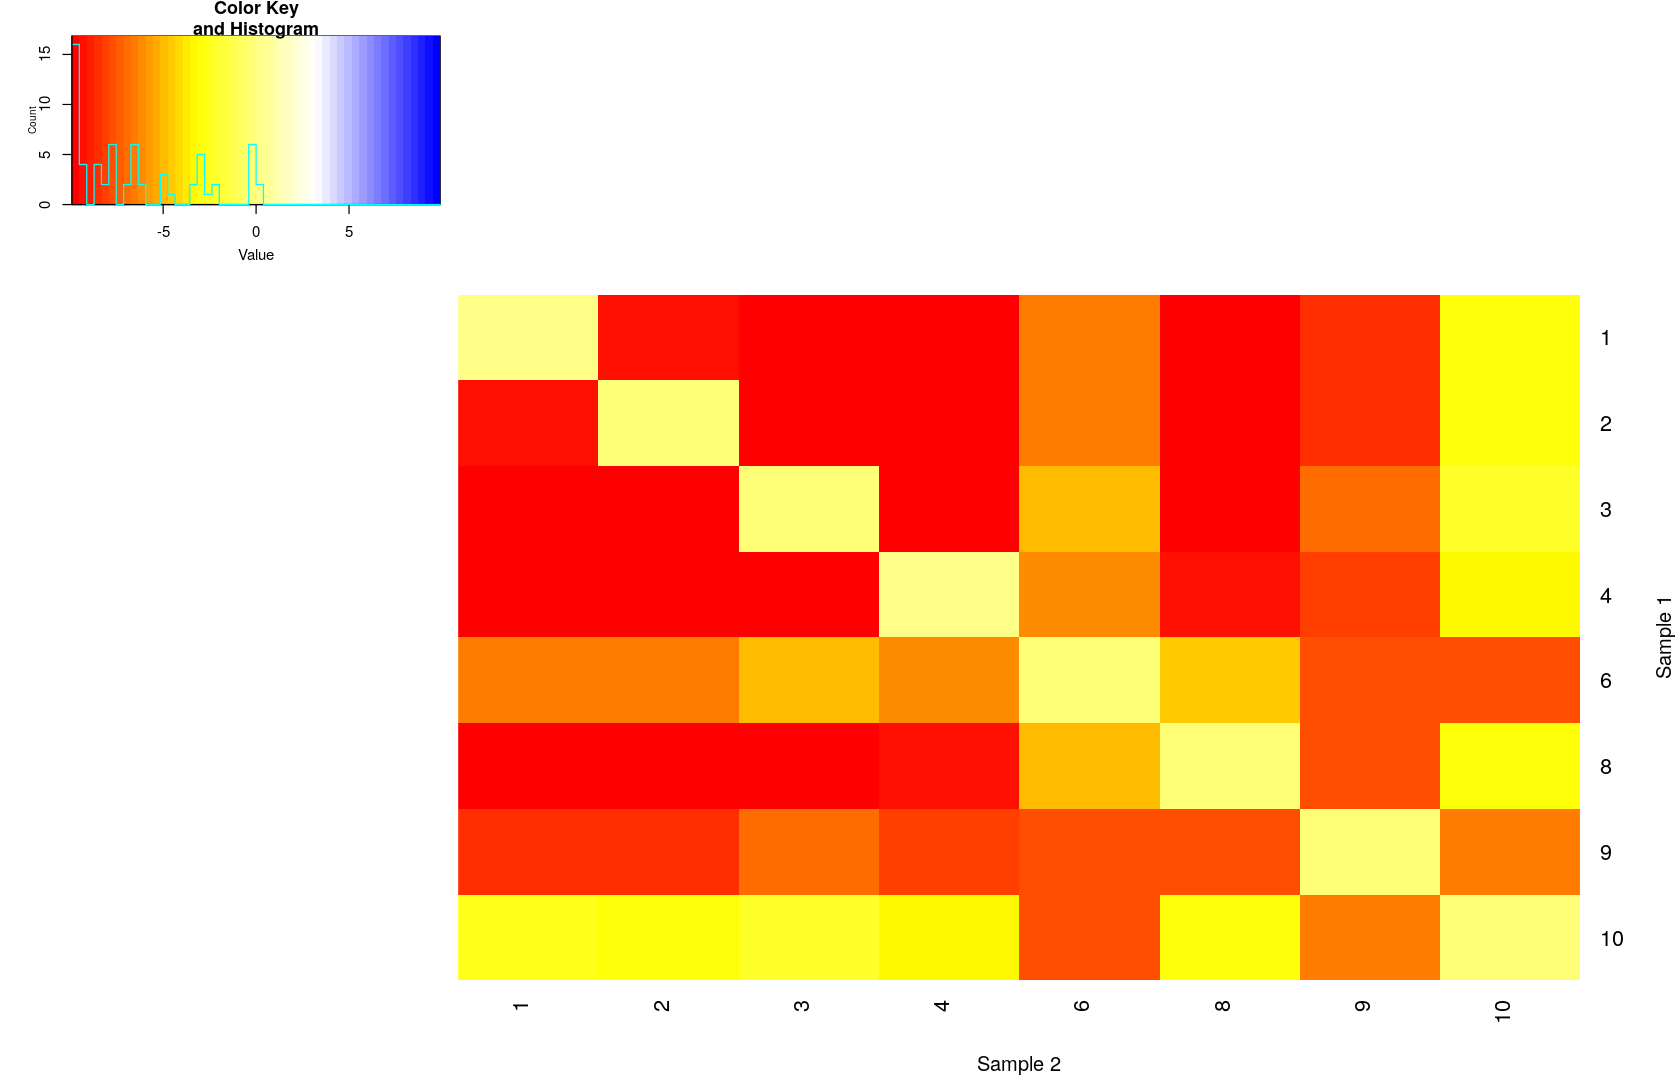

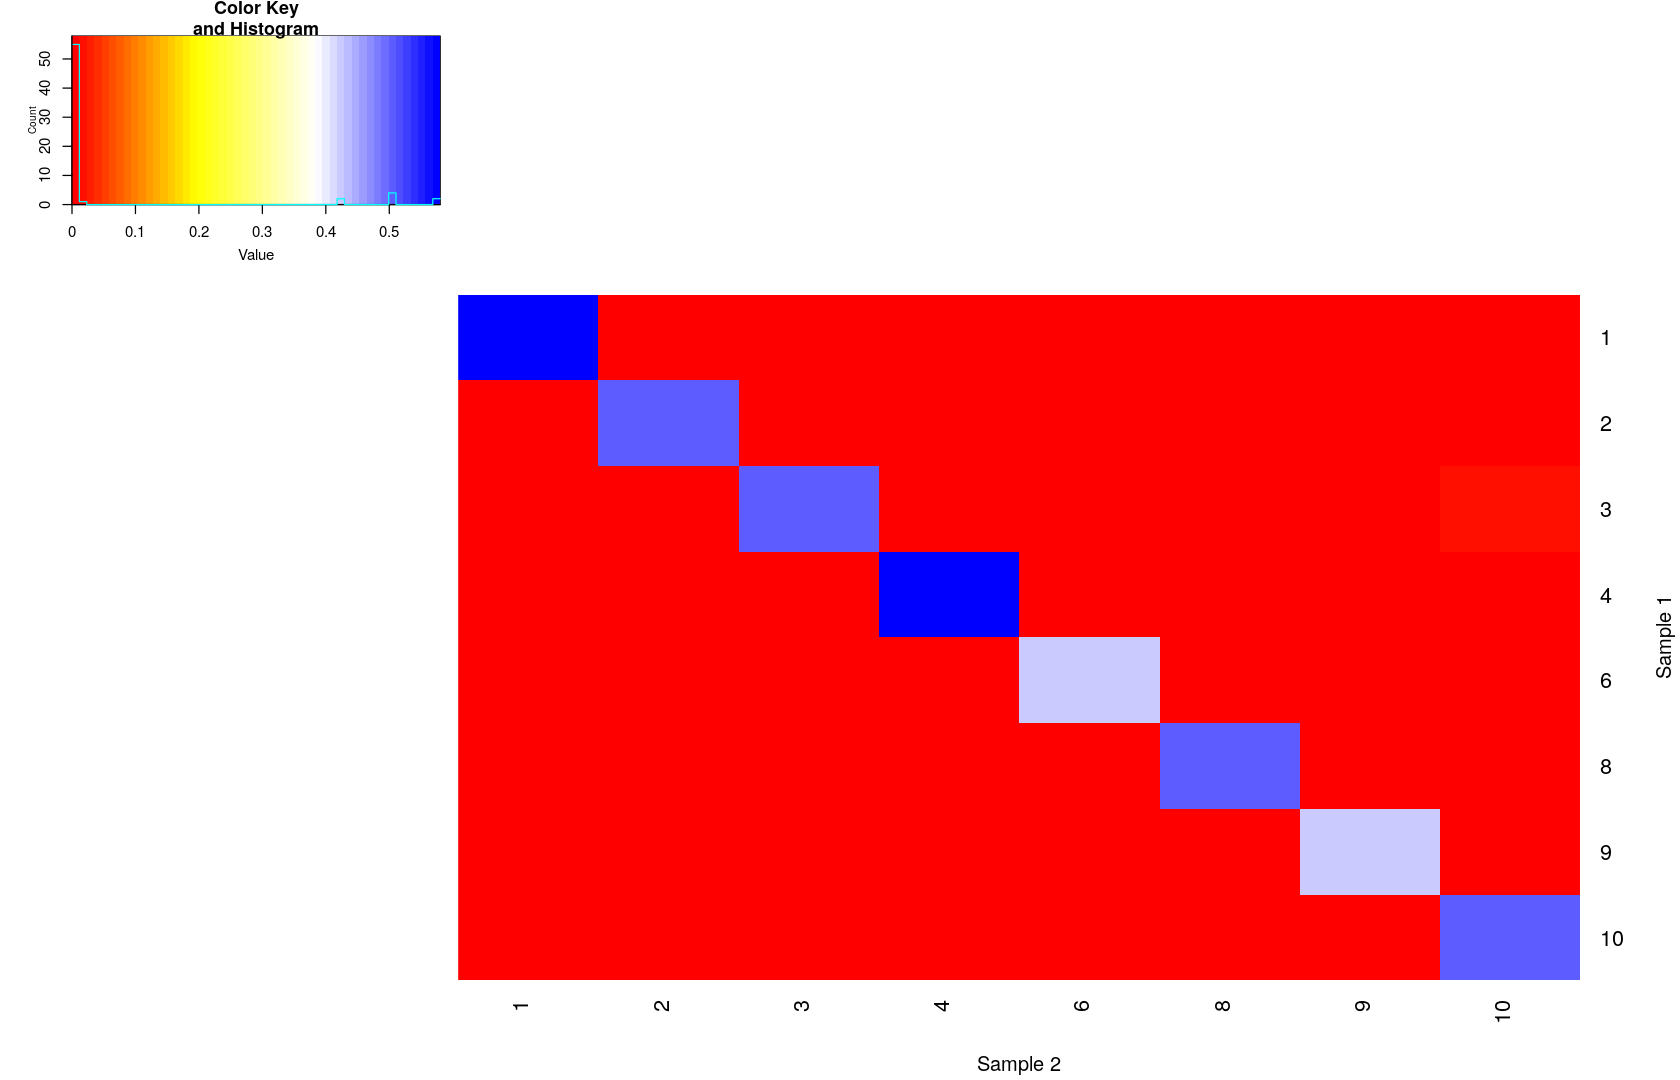

In [22]:
par(mar=c(0,0,0,0))
heatmapCols <- colorRampPalette(c("red","yellow","white","blue"))(50)

heatmap.2(
    res0@ww,
    trace="none",
    col=heatmapCols,
    symm=FALSE,
    dendrogram="none",
    Rowv=FALSE,
    Colv=FALSE,
    xlab="Sample 2",
    ylab="Sample 1")

par(mar=c(0,0,0,0))
heatmapCols <- colorRampPalette(c("red","yellow","white","blue"))(50)
heatmap.2(res0@pNorm,trace="none",col=heatmapCols,symm=FALSE,dendrogram="none",
Rowv=FALSE,Colv=FALSE,xlab="Sample 2",ylab="Sample 1")

### Comparing cluster label 1 in sample 1 and sample 2
Now I compared the cluster 01 in sample 1 and sample 2. Before MPSK calibration, you can observe the seperation of blue and  nodes (represent sample 1 and sample 2 respectively).

Warning message in graph.adjacency(distmat * mstree, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”Warning message in graph.adjacency(distmat, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”

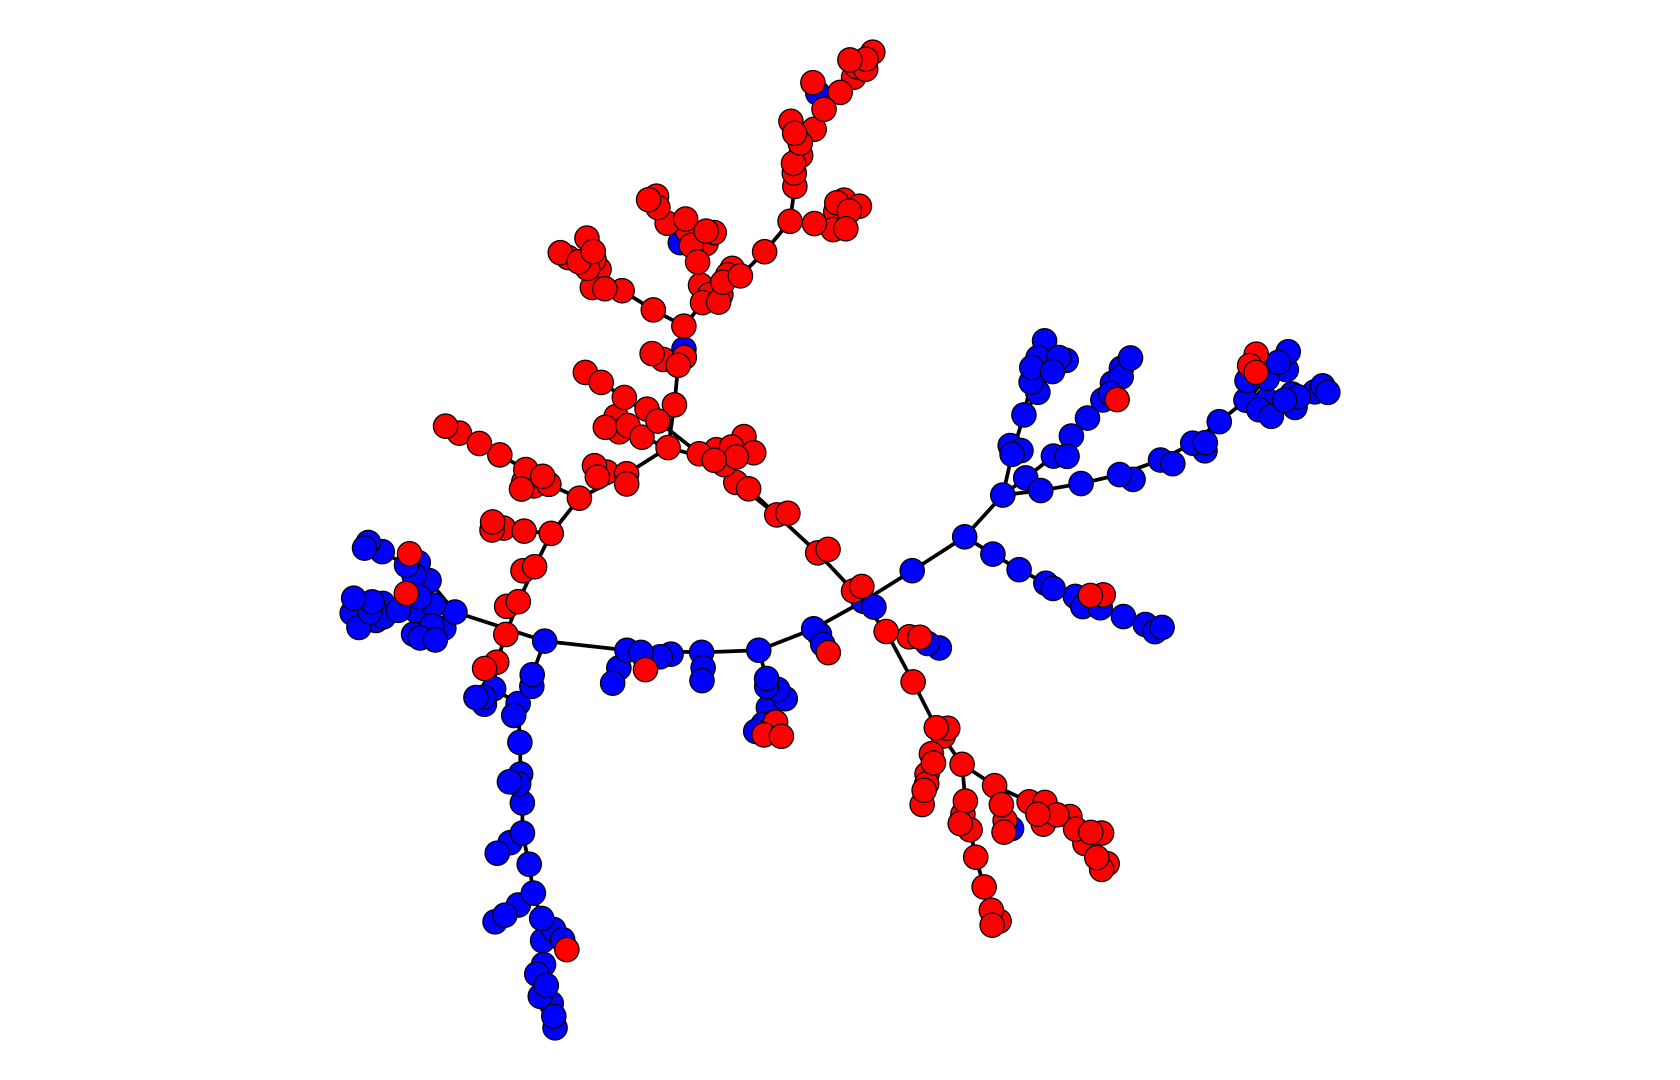

In [23]:
###
tmp1 = dat1_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 1) %>% sample_frac(size = 0.1)
tmp2 = dat2_clust1_raw %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 2) %>% sample_frac(size = 0.1)
dat_sub = rbind(tmp1, tmp2)

###
set.seed(123)
g1 = makeFRMST(dat_sub)

###
par(mar=c(0,0,0,0))
plot(g1$g, 
     vertex.label.cex=0.01,
     layout=layout.fruchterman.reingold(g1$g))

After MPSK calibration, the distribution of the nodes of both population merged together in the tree.

Warning message in graph.adjacency(distmat * mstree, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”Warning message in graph.adjacency(distmat, mode = "undirected", weighted = TRUE, :
“Same attribute for columns and rows, row names are ignored”

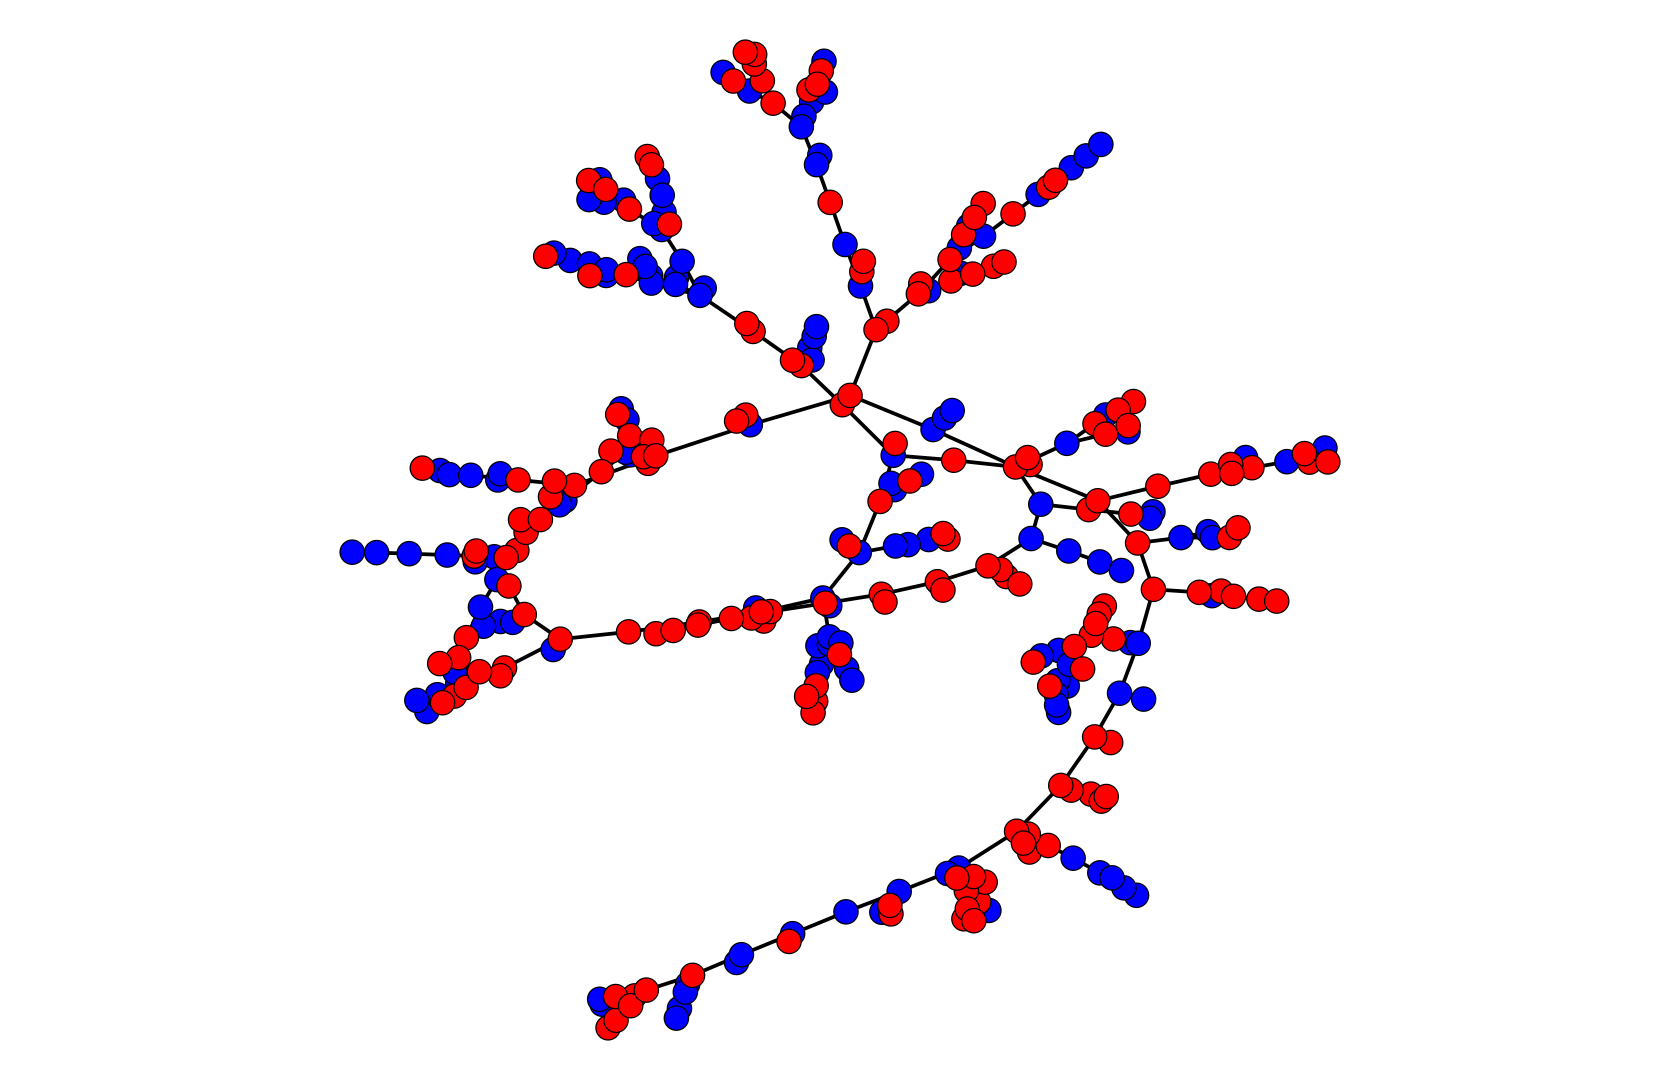

In [24]:
###
tmp1 = dat1_clust1_cal %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 1) %>% sample_frac(size = 0.1)
tmp2 = dat2_clust1_cal %>% dplyr::select(-cluster) %>% dplyr::mutate(sam = 2) %>% sample_frac(size = 0.1)
dat_sub = rbind(tmp1, tmp2)

###
set.seed(123)
g1 = makeFRMST(dat_sub)

###
par(mar=c(0,0,0,0))
plot(g1$g, 
     vertex.label.cex=0.01,
     layout=layout.fruchterman.reingold(g1$g))

### Comparing all clusters in sample 01 (lab 1) and sample 02 (lab 2)
The authors of flowmap define a nonparametric statistic that quantify the separation of two color of nodes in a minimum tree. Below I compared all clusters in sample 1 (lab 1) and sample 2 (lab 2) before calibration and the distance matrix is plotted.

**Before MPSK calibration**

In [34]:
tmp1 = dat1_raw
colnames(tmp1) = colnames(tmp1) %>% recode("cluster" = "id")

tmp2 = dat2_raw
colnames(tmp2) = colnames(tmp2) %>% recode("cluster" = "id")


res1 = getFRest(
    tmp1, tmp2,
    #sampleMethod="equalSize",
    sampleMethod="proportional",
    sampleSize=100,
    ndraws=100,
    estStat="median",
    ncores=NULL)

computing on 24 cores
computing FR statistics between sample ... 



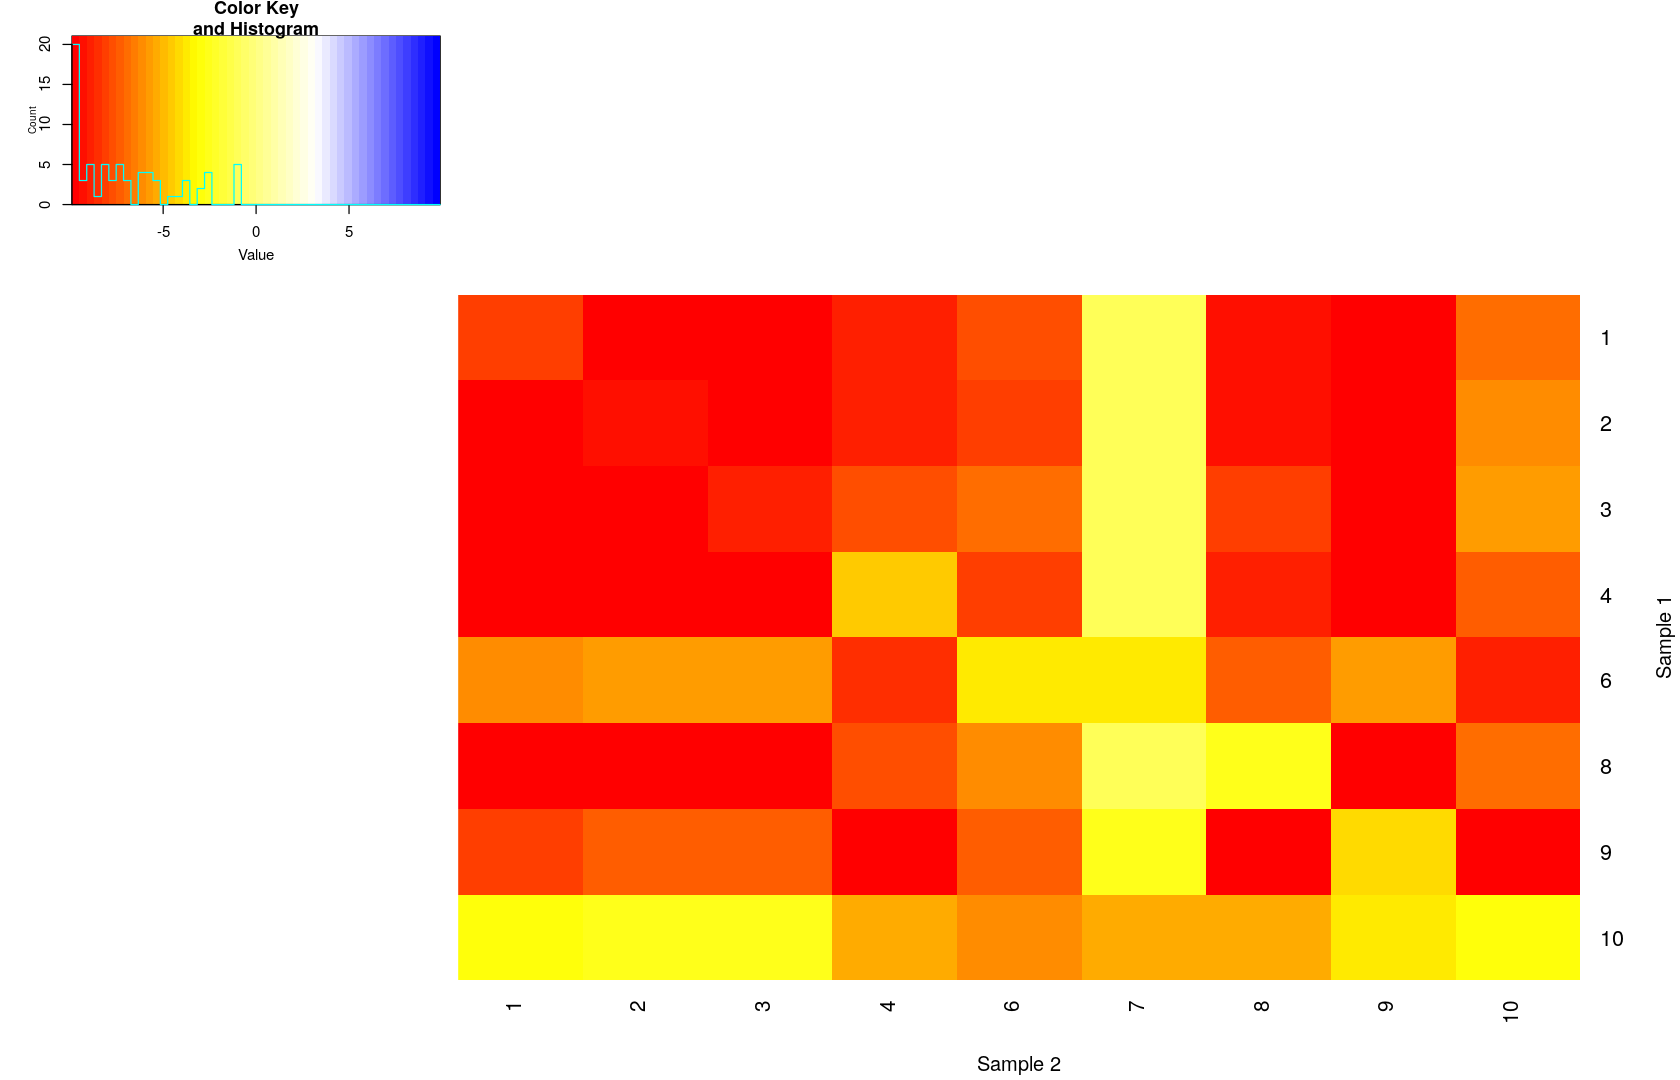

In [35]:
par(mar=c(0,0,0,0))
heatmapCols <- colorRampPalette(c("red","yellow","white","blue"))(50)

heatmap.2(
    res1@ww,
    trace="none",
    col=heatmapCols,
    symm=FALSE,
    dendrogram="none",
    Rowv=FALSE,
    Colv=FALSE,
    xlab="Sample 2",
    ylab="Sample 1")

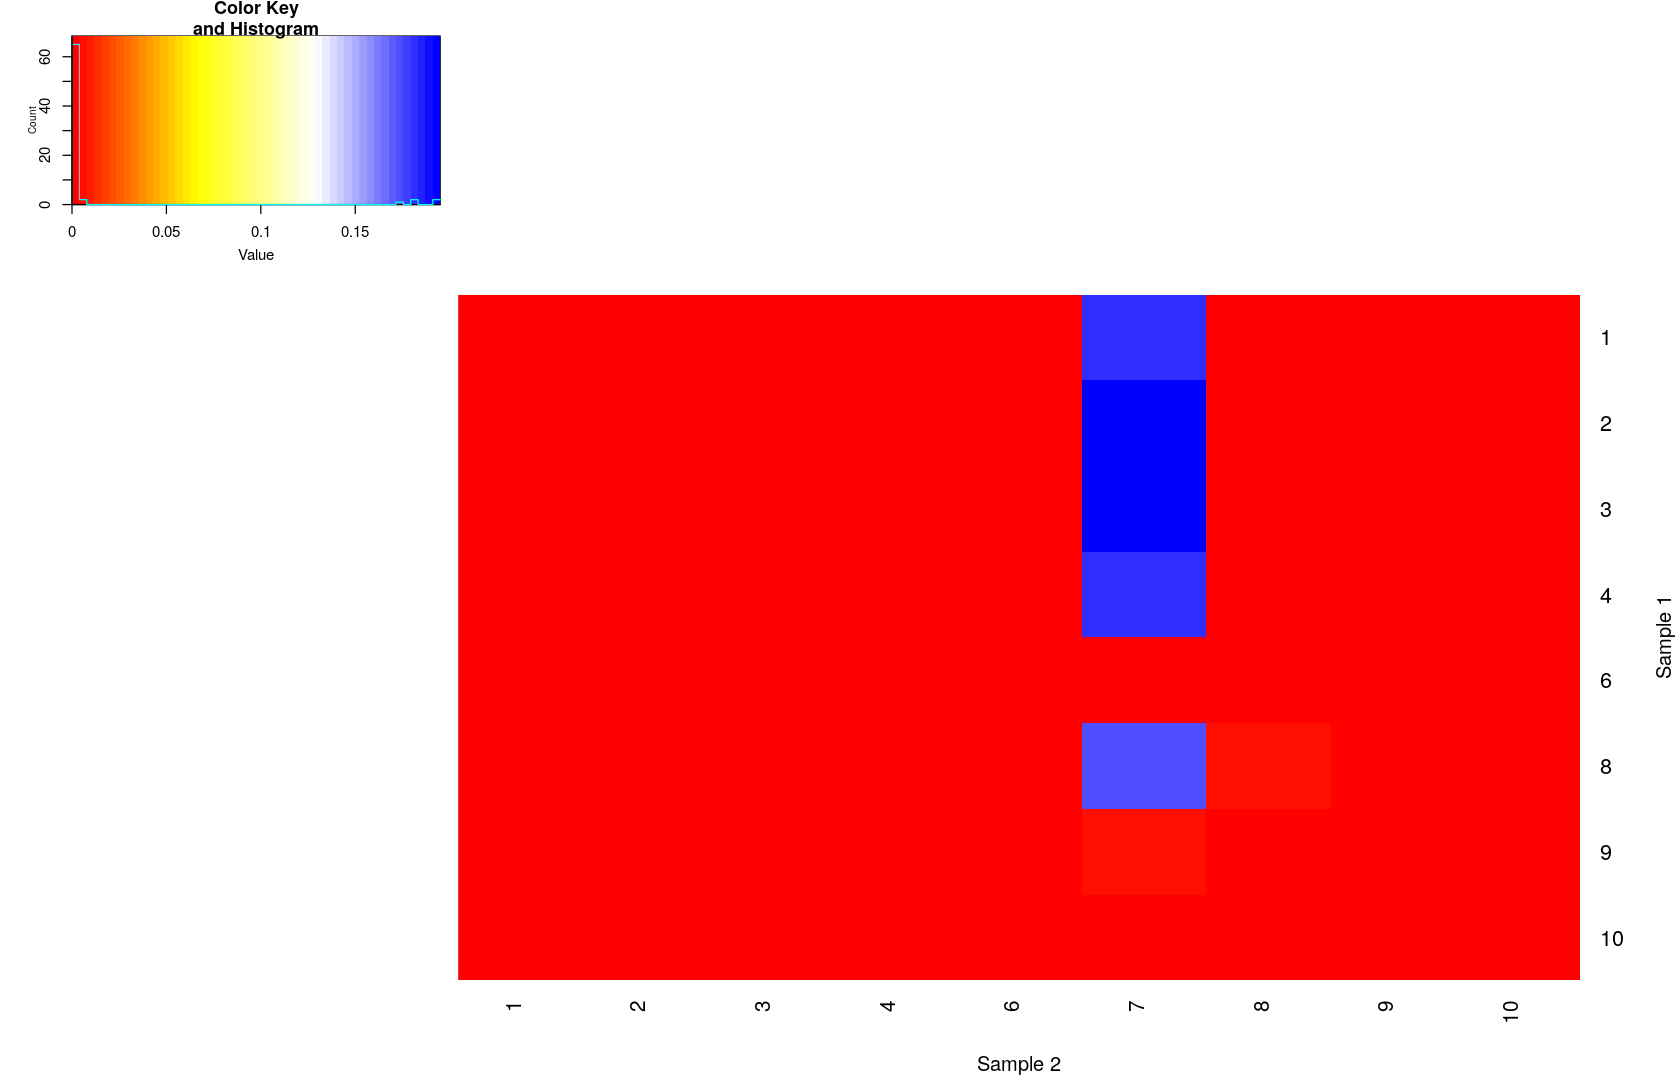

In [36]:
par(mar=c(0,0,0,0))
heatmapCols <- colorRampPalette(c("red","yellow","white","blue"))(50)
heatmap.2(res1@pNorm,trace="none",col=heatmapCols,symm=FALSE,dendrogram="none",
Rowv=FALSE,Colv=FALSE,xlab="Sample 2",ylab="Sample 1")

**After MPSK calibration**

After calibration the distance of diagnonal decrease

In [37]:
tmp1 = dat1_cal
colnames(tmp1) = colnames(tmp1) %>% recode("cluster" = "id")

tmp2 = dat2_cal
colnames(tmp2) = colnames(tmp2) %>% recode("cluster" = "id")

res2 = getFRest(
    tmp1, tmp2,
    sampleMethod="proportional",
    sampleSize=100,
    ndraws=100,
    estStat="median",
    ncores=NULL)

computing on 24 cores
computing FR statistics between sample ... 



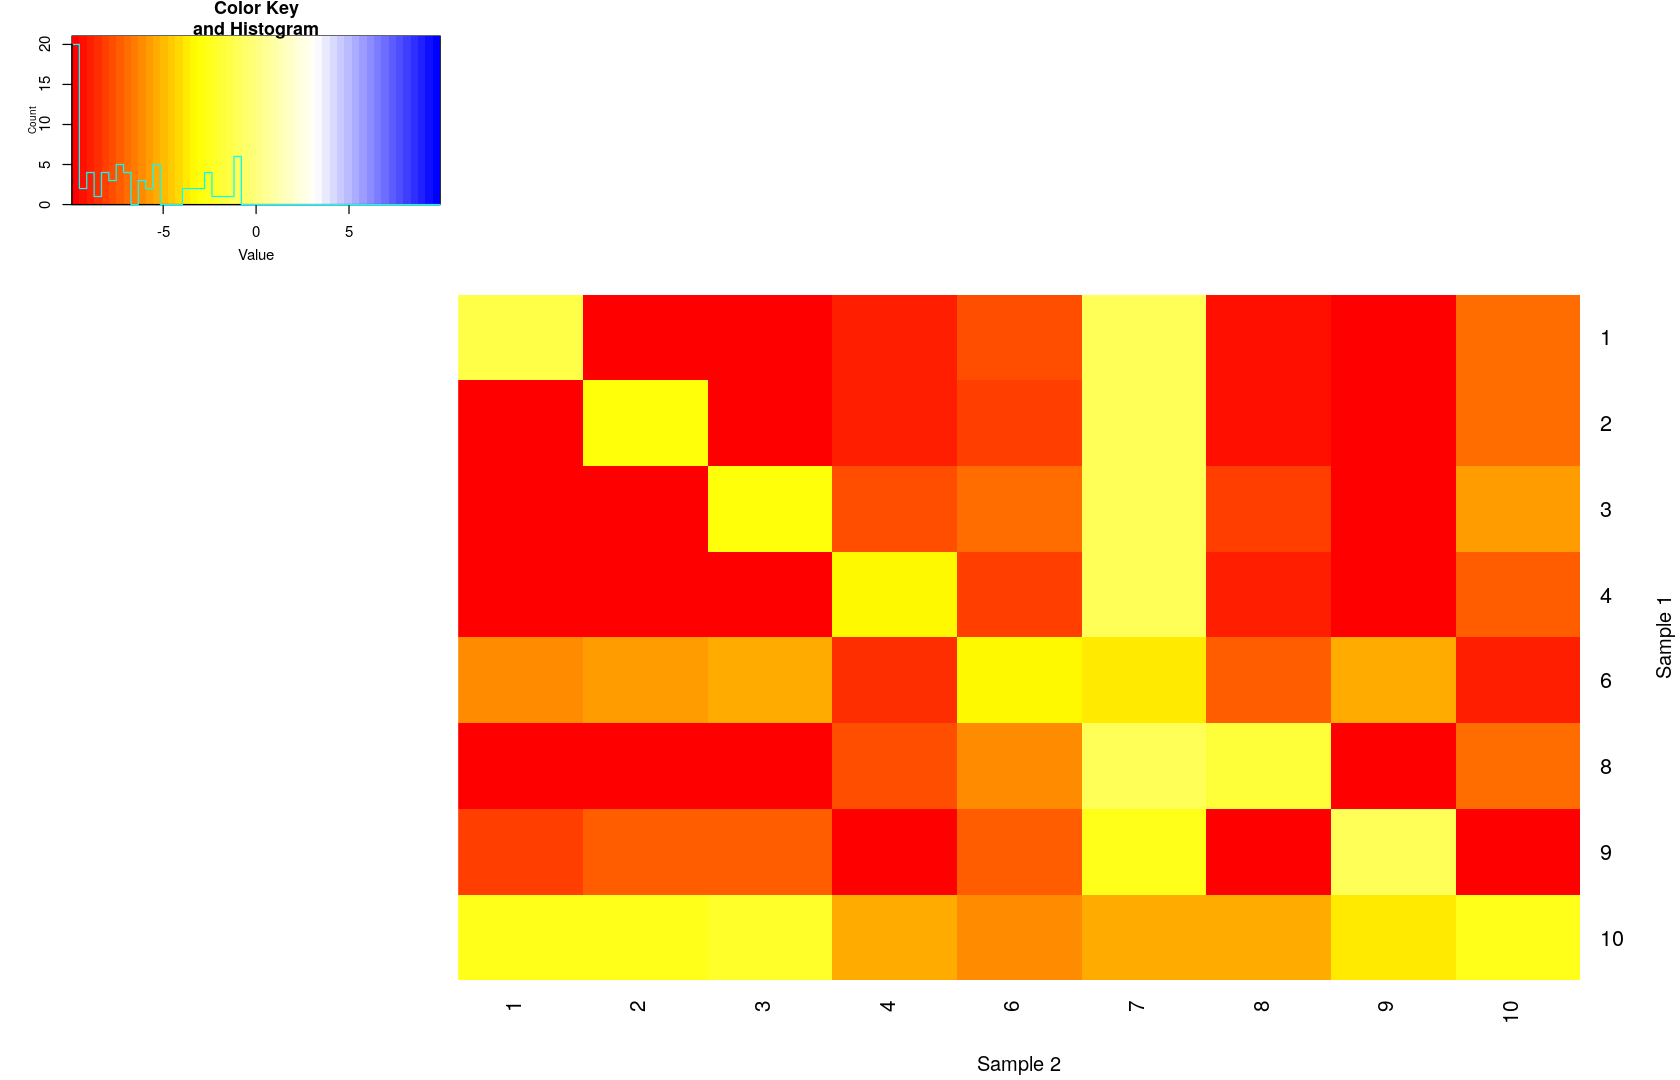

In [38]:
par(mar=c(0,0,0,0))
heatmapCols <- colorRampPalette(c("red","yellow","white","blue"))(50)

heatmap.2(
    res2@ww,
    trace="none",
    col=heatmapCols,
    symm=FALSE,
    dendrogram="none",
    Rowv=FALSE,
    Colv=FALSE,
    xlab="Sample 2",
    ylab="Sample 1")

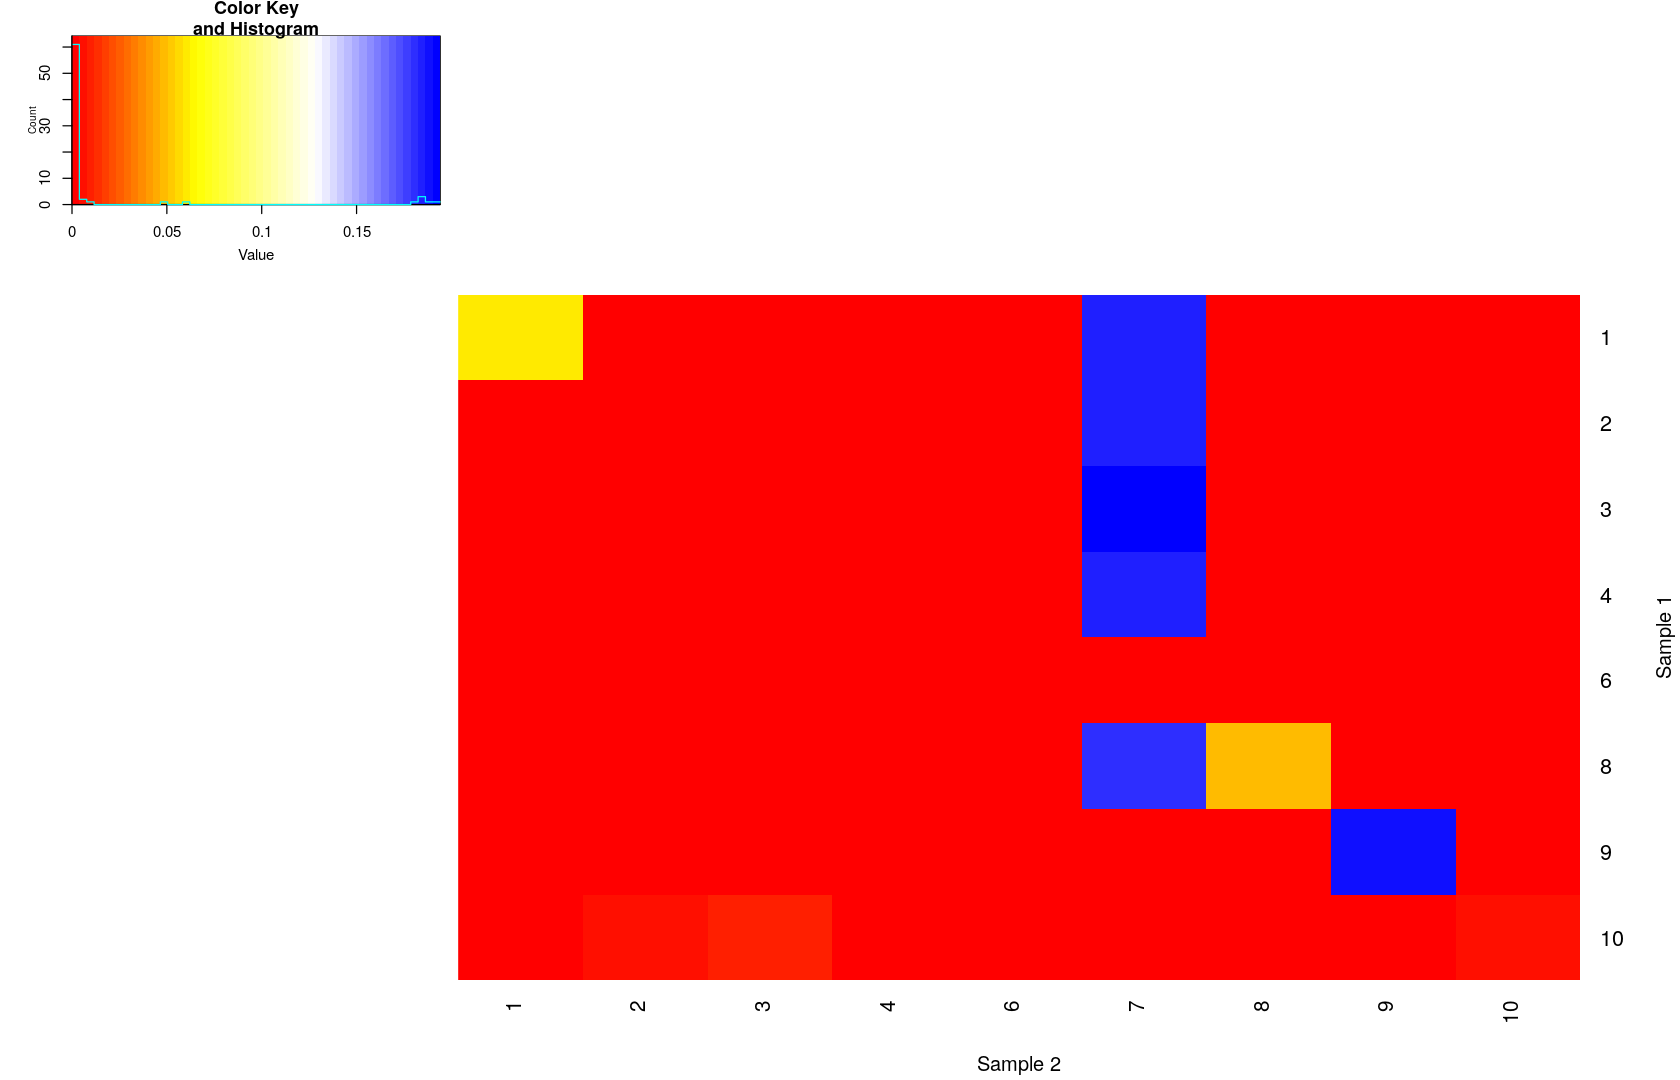

In [39]:
par(mar=c(0,0,0,0))
heatmapCols <- colorRampPalette(c("red","yellow","white","blue"))(50)
heatmap.2(res2@pNorm,trace="none",col=heatmapCols,symm=FALSE,dendrogram="none",
Rowv=FALSE,Colv=FALSE,xlab="Sample 2",ylab="Sample 1")